# Cosmic Commodity Charts


Predicting prices of commodity futures according to the positions of solar system planets. 

Stock market data: [Quandl](https://www.quandl.com/)   
Astronomical data: [NASA Jet Propulsion Laboratory de430 ephemeris [PDF]](https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430_and_de431.pdf)   
accessed via [Skyfield](https://rhodesmill.org/skyfield/)

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Chart title and query

In [2]:
# all commodity options

commodities = {
    # Grain and foods
    "Corn": "CHRIS/CME_C1",
    "Wheat": "CHRIS/CME_W3",
    "Soybean": "CHRIS/CME_S3",
    "Rough Rice": "CHRIS/CME_RR1", # only goes back to 1986
    "Cotton No.2": "CHRIS/ICE_CT2",
    "Sugar": "CHRIS/ICE_SB2",
    "Orange Juice": "CHRIS/ICE_OJ4",
    "Coffee C": "CHRIS/ICE_KC3",
    # Livestock
    "Live Cattle": "CHRIS/CME_LC3",
    "Feeder Cattle": "CHRIS/CME_FC2",
    "Lean Hog": "CHRIS/CME_LN4",
    # energy
    "Crude Oil": "CHRIS/CME_CL38",
    # Metals
    "Copper": "CHRIS/CME_HG2",
    # Precious
    "Gold": "CHRIS/CME_GC5",
    "Silver": "CHRIS/CME_SI7",
    }

In [3]:
# planet options

planet_lists = {
    "Full": ['mercury', 'venus', 'earth', 'mars',
            'jupiter', 'saturn', 'uranus', 'neptune', 'pluto'],
    "Inner": ['mercury', 'venus', 'earth', 'mars']
}

In [4]:
# chart lengths in days

lengths = [365, 730]

In [5]:
# Build the query

from random import choice

plans = list(planet_lists.keys())
coms = list(commodities.keys())

query = [choice(plans), choice(coms), choice(lengths)]
print("{0} {1} Chart, {2} Days".format(*query))

Full Soybean Chart, 730 Days


## Commodity Price

In [6]:
import quandl

with open("../_data/quandl-key.txt", "r") as text:
    for line in text:
        quandl_key = line
quandl.ApiConfig.api_key = quandl_key

In [7]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days = 10950) # 30 years ago

commodities = {
    "Corn": "CHRIS/CME_C1",
    "Wheat": "CHRIS/CME_W3",
    "Soybean": "CHRIS/CME_S3",
    "Rough Rice": "CHRIS/CME_RR1", # only goes back to 1986
    "Cotton No.2": "CHRIS/ICE_CT2",
    "Sugar": "CHRIS/ICE_SB2",
    "Orange Juice": "CHRIS/ICE_OJ4",
    "Coffee C": "CHRIS/ICE_KC3",
    # Livestock
    "Live Cattle": "CHRIS/CME_LC3",
    "Feeder Cattle": "CHRIS/CME_FC2",
    "Lean Hog": "CHRIS/CME_LN4",
    # energy
    "Crude Oil": "CHRIS/CME_CL38",
    # Metals
    "Copper": "CHRIS/CME_HG2",
    "Zinc": "CHRIS/SHFE_ZN3", # only goes back to 2007
    # Precious
    "Gold": "CHRIS/CME_GC5",
    "Silver": "CHRIS/CME_SI7",
    }

price_data_30y = quandl.get(commodities[query[1]], start_date=start_date, end_date=today)
price_data_30y.head()

Open    High     Low    Last  Change  Settle   Volume  \
Date                                                                  
1989-11-30  609.00  610.25  606.75  607.25     NaN  607.25   7850.0   
1989-12-01  607.75  609.75  601.25  601.75     NaN  601.75  12380.0   
1989-12-04  600.00  600.00  596.50  597.00     NaN  597.00  10960.0   
1989-12-05  597.50  600.75  597.00  599.75     NaN  599.75   8640.0   
1989-12-06  600.00  604.25  597.00  603.50     NaN  603.50  12810.0   

            Previous Day Open Interest  
Date                                    
1989-11-30                     74900.0  
1989-12-01                     75750.0  
1989-12-04                     75310.0  
1989-12-05                     76665.0  
1989-12-06                     79635.0

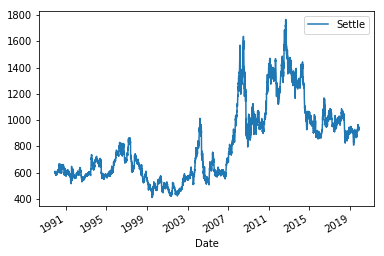

In [8]:
price_data_30y.plot(y="Settle")

## Planets & Orbits Training Data

In [9]:
# load skyfield and ephemeris
from skyfield.api import load, Loader
from astropy import units as u

# Skyfield data
load = Loader('../_data/skyfield')
planets = load('de430.bsp')
ts = load.timescale()

In [10]:
planet_lists = {
    "Full": ['mercury', 'venus', 'earth', 'mars', 
            'jupiter', 'saturn', 'uranus', 'neptune', 'pluto'],
    "Inner": ['mercury', 'venus', 'earth', 'mars'],
    "Outer": ['jupiter', 'saturn', 'uranus', 'neptune', 'pluto']
}

In [11]:
planet_list = planet_lists[query[0]]

In [12]:
def add_planet_positions(df, planet_list):
    '''
    input: dataframe with datetime index, list of planets
    output: dataframe with planet distance (barycentric) columns
            added for the planets in planet_list and dates in df.index
    '''
    for planet in planet_list:
        query_name = planet + " barycenter"
        col_name = planet + "_dist"
        p = planets[query_name]
        df[col_name] = p.at(ts.utc(df.index)).distance().to(u.km)
    return df

### Scaling

The planet positions are scaled according to their relative orbits, with 0.0 and 1.0 as the closest and furthest points from the solar system barycentre on that planet's orbit.
![](https://gitlab.com/davidbenque/almanac.computer/raw/master/Cosmic%20Commodity%20Chart/_notebook_images/solar_system_distances_notebook_2.png)

In [13]:
# Mininum and maximum for each orbit 
# 300 year window to allow for a full orbit of Pluto
# exported to a CSV file to avoid computing them each time
planets_minmax = pd.read_csv("planets_minmax.csv", index_col = 0)
planets_minmax

min           max
mercury_dist  4.473931e+07  7.108315e+07
venus_dist    1.062104e+08  1.102090e+08
earth_dist    1.458724e+08  1.533281e+08
mars_dist     2.052792e+08  2.505484e+08
jupiter_dist  7.390777e+08  8.158063e+08
saturn_dist   1.346026e+09  1.508435e+09
uranus_dist   2.735045e+09  3.006735e+09
neptune_dist  4.459924e+09  4.536853e+09
pluto_dist    4.435661e+09  7.375996e+09

In [14]:
def orbit_scaler(planet_dist, x):
    min_dist, max_dist = planets_minmax.loc[planet_dist]
    return ((x - min_dist)/(max_dist-min_dist))

In [15]:
training_data = price_data_30y["Settle"].to_frame()
training_data["Date"] = training_data.index

import pytz
from pytz import timezone

utc = timezone('UTC')
def to_utc(x):
    # add utc timezone to datetime index
    a = x.replace(tzinfo=pytz.utc)
    return a

training_data["Date"] = training_data["Date"].apply(to_utc)
training_data.set_index(['Date'], inplace=True)
training_data = training_data.rename(columns={"Settle":"Price"})
training_data = add_planet_positions(training_data, planet_list)
training_data.head()

Price  mercury_dist    venus_dist    earth_dist  \
Date                                                                          
1989-11-30 00:00:00+00:00  607.25  6.810045e+07  1.081717e+08  1.475215e+08   
1989-12-01 00:00:00+00:00  601.75  6.770740e+07  1.081548e+08  1.474997e+08   
1989-12-04 00:00:00+00:00  597.00  6.629697e+07  1.081041e+08  1.474381e+08   
1989-12-05 00:00:00+00:00  599.75  6.575223e+07  1.080873e+08  1.474188e+08   
1989-12-06 00:00:00+00:00  603.50  6.517171e+07  1.080705e+08  1.474001e+08   

                              mars_dist  jupiter_dist   saturn_dist  \
Date                                                                  
1989-11-30 00:00:00+00:00  2.374056e+08  7.688738e+08  1.500307e+09   
1989-12-01 00:00:00+00:00  2.372357e+08  7.689272e+08  1.500298e+09   
1989-12-04 00:00:00+00:00  2.367209e+08  7.690873e+08  1.500268e+09   
1989-12-05 00:00:00+00:00  2.365477e+08  7.691407e+08  1.500258e+09   
1989-12-06 00:00:00+00:00  2.363737e+08  7.691942e+08  1.500248e+09   

                            uranus_dist  neptune_dist    pluto_dist  
Date                                                                 
1989-11-30 00:00:00+00:00  2.898312e+09  4.519473e+09  4.436520e+09  
1989-12-01 00:00:00+00:00  2.898338e+09  4.519470e+09  4.436521e+09  
1989-12-04 00:00:00+00:00  2.898419e+09  4.519460e+09  4.436523e+09  
1989-12-05 00:00:00+00:00  2.898446e+09  4.519457e+09  4.436524e+09  
1989-12-06 00:00:00+00:00  2.898473e+09  4.519453e+09  4.436524e+09

In [16]:
target = training_data["Price"]
features = training_data.drop(["Price"], axis=1)

In [17]:
planet_distances = plt.figure(figsize=(9,7))
ax = plt.subplot()
for c in list(features):
    line = ax.plot(features.index, features[c], label=c.split("_")[0], linewidth=1)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)

In [18]:
features_scaled = pd.DataFrame()
for column in features:
    features_scaled[column] = orbit_scaler(column, features[column])

planet_distances_scaled = plt.figure(figsize=(9,7))
ax = plt.subplot()
for c in list(features_scaled):
    line = ax.plot(features_scaled.index, features_scaled[c], label=c.split("_")[0], linewidth=1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)    

## Training

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled.values, target.values, test_size=0.3, random_state=0)

In [20]:
from sklearn import svm

clf = svm.SVR(kernel='rbf')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.17058580436119397

## Prediction

In [21]:
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
end_date = tomorrow + datetime.timedelta(days=query[2])
dates = pd.date_range(tomorrow, end_date, freq = 'D', tz='utc')
dates = pd.to_datetime(dates)
future = pd.DataFrame(index=dates, columns=['A'])
future = add_planet_positions(future, planet_list)
future.drop(["A"], axis=1, inplace=True)

# scale
for column in future:
    future[column] = orbit_scaler(column, future[column])

# predict price
future["pred_price"] = clf.predict(future.values)

# export 
future["pred_price"].to_csv("_temp/pred_price.csv")

future.head()

mercury_dist  venus_dist  earth_dist  mars_dist  \
2019-11-24 00:00:00+00:00      0.195543    0.374960    0.345818   0.846282   
2019-11-25 00:00:00+00:00      0.219898    0.376914    0.344221   0.843307   
2019-11-26 00:00:00+00:00      0.245800    0.378945    0.342675   0.840306   
2019-11-27 00:00:00+00:00      0.272998    0.381054    0.341181   0.837278   
2019-11-28 00:00:00+00:00      0.301246    0.383239    0.339739   0.834223   

                           jupiter_dist  saturn_dist  uranus_dist  \
2019-11-24 00:00:00+00:00      0.571786     0.950731     0.849069   
2019-11-25 00:00:00+00:00      0.571076     0.950642     0.848998   
2019-11-26 00:00:00+00:00      0.570365     0.950553     0.848927   
2019-11-27 00:00:00+00:00      0.569655     0.950464     0.848857   
2019-11-28 00:00:00+00:00      0.568944     0.950375     0.848786   

                           neptune_dist  pluto_dist  pred_price  
2019-11-24 00:00:00+00:00      0.225019    0.217084  839.774863  
2019-11-25 00:00:00+00:00      0.224975    0.217118  839.996188  
2019-11-26 00:00:00+00:00      0.224930    0.217151  840.212310  
2019-11-27 00:00:00+00:00      0.224885    0.217184  840.419148  
2019-11-28 00:00:00+00:00      0.224841    0.217217  840.613133

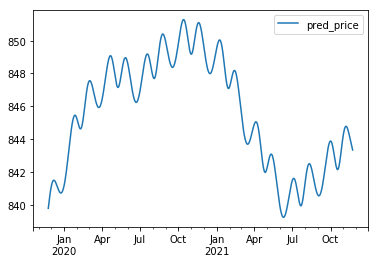

In [22]:
future.plot(y="pred_price")

In [23]:
future["change"] = future["pred_price"] - future["pred_price"].shift(-1)
price_preds = future[["pred_price", "change"]].copy()
price_preds = price_preds.fillna(0)
price_preds['direction'] = price_preds.change.map(lambda x: 0 if x == 0 else x/abs(x))
price_preds['dir_change'] = (price_preds.direction != price_preds.direction.shift(1)).astype(int)

# remove change flag for first and last dates
for date in [tomorrow, end_date]:
    price_preds.set_value(date, 'dir_change', 0) 
    
price_preds["block"] = price_preds.dir_change.cumsum()
price_preds.head()

/home/david/.local/share/virtualenvs/Monistic_Almanac-me3ioVh4/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


pred_price    change  direction  dir_change  block
2019-11-24 00:00:00+00:00  839.774863 -0.221325       -1.0           0      0
2019-11-25 00:00:00+00:00  839.996188 -0.216123       -1.0           0      0
2019-11-26 00:00:00+00:00  840.212310 -0.206837       -1.0           0      0
2019-11-27 00:00:00+00:00  840.419148 -0.193985       -1.0           0      0
2019-11-28 00:00:00+00:00  840.613133 -0.178147       -1.0           0      0

In [24]:
# Format and Output peaks and valleys data

# remove weird warning for now
pd.options.mode.chained_assignment = None

#select rows with a direction change
peaks_valleys = price_preds.loc[price_preds["dir_change"] == 1]

#dump unncessary columns
peaks_valleys.drop(["change","dir_change", "block"], axis=1, inplace=True)

# make a date column, format and dump the index
peaks_valleys["date"] = peaks_valleys.index
#peaks_valleys["date"] = peaks_valleys["date"].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))
peaks_valleys = peaks_valleys.reset_index(drop=True)

# truncate price to 2 decimals
#peaks_valleys["pred_price"] = peaks_valleys["pred_price"].apply(lambda x: '%.2f'%(x))

# export csv wihtout the index column
peaks_valleys.to_csv("_temp/peaks_valleys.csv", index=False)
peaks_valleys

pred_price  direction                      date
0   841.486027        1.0 2019-12-07 00:00:00+00:00
1   840.708833       -1.0 2019-12-24 00:00:00+00:00
2   845.453643        1.0 2020-01-27 00:00:00+00:00
3   844.620229       -1.0 2020-02-09 00:00:00+00:00
4   847.557736        1.0 2020-03-02 00:00:00+00:00
5   845.922454       -1.0 2020-03-24 00:00:00+00:00
6   849.083526        1.0 2020-04-21 00:00:00+00:00
7   847.146554       -1.0 2020-05-09 00:00:00+00:00
8   848.961004        1.0 2020-05-27 00:00:00+00:00
9   846.235501       -1.0 2020-06-22 00:00:00+00:00
10  849.182710        1.0 2020-07-19 00:00:00+00:00
11  847.688958       -1.0 2020-08-04 00:00:00+00:00
12  850.404279        1.0 2020-08-25 00:00:00+00:00
13  848.372492       -1.0 2020-09-17 00:00:00+00:00
14  851.281445        1.0 2020-10-14 00:00:00+00:00
15  849.172357       -1.0 2020-11-01 00:00:00+00:00
16  851.097627        1.0 2020-11-19 00:00:00+00:00
17  847.990035       -1.0 2020-12-16 00:00:00+00:00
18  850.044612        1.0 2021-01-08 00:00:00+00:00
19  847.080302       -1.0 2021-01-29 00:00:00+00:00
20  848.182510        1.0 2021-02-12 00:00:00+00:00
21  843.683764       -1.0 2021-03-16 00:00:00+00:00
22  845.052088        1.0 2021-04-05 00:00:00+00:00
23  841.966451       -1.0 2021-04-27 00:00:00+00:00
24  843.077891        1.0 2021-05-12 00:00:00+00:00
25  839.226117       -1.0 2021-06-10 00:00:00+00:00
26  841.600419        1.0 2021-07-05 00:00:00+00:00
27  839.930071       -1.0 2021-07-22 00:00:00+00:00
28  842.495473        1.0 2021-08-11 00:00:00+00:00
29  840.535895       -1.0 2021-09-03 00:00:00+00:00
30  843.879361        1.0 2021-10-01 00:00:00+00:00
31  842.138410       -1.0 2021-10-18 00:00:00+00:00
32  844.777843        1.0 2021-11-07 00:00:00+00:00

## Charting layers

In [25]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

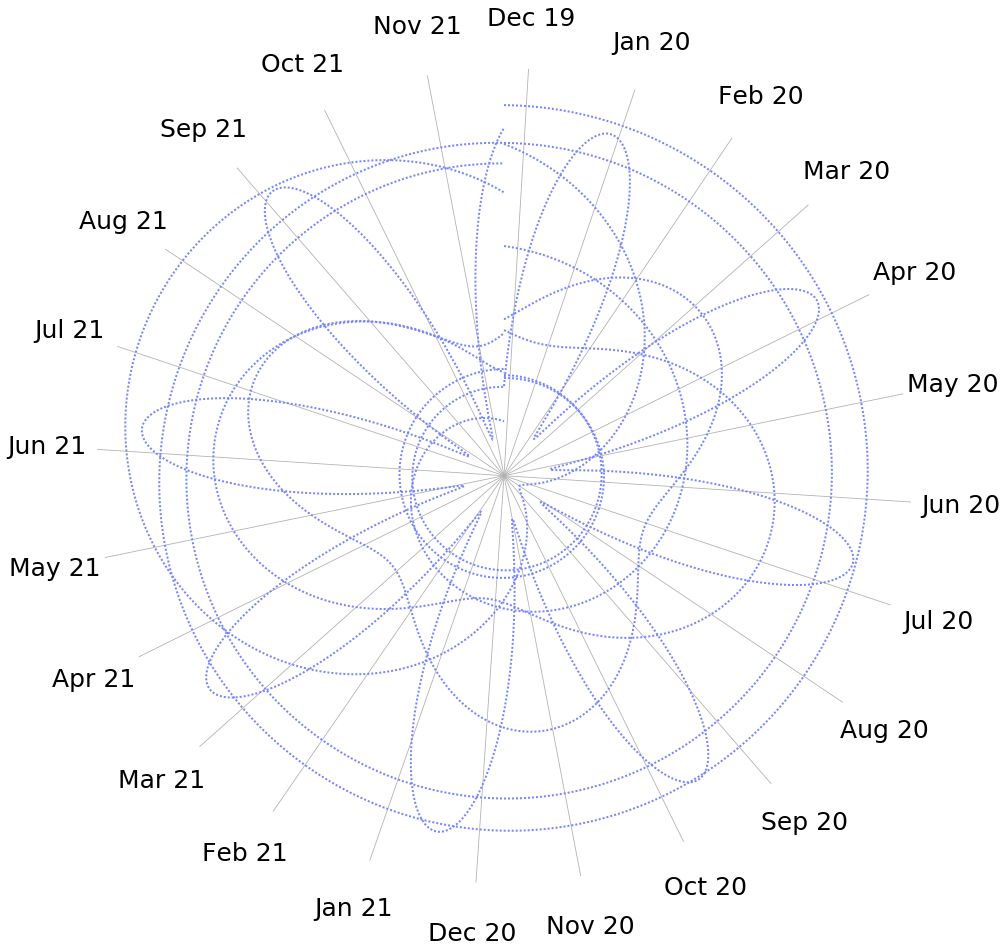

In [26]:
# Features (planets) chart

# months for axis ticks - fill month_starts and drop columns
future["month"] = future.index.strftime('%m').astype(int)
future["month_diff"] = future.month.diff().fillna(0)
month_starts = future.loc[future['month_diff'] != 0]
future.drop(["month","month_diff"], axis=1,inplace=True)

# remove backgrounds (has to be specified again for savefig())
plt.rcParams['figure.facecolor'] = ((0,0,0,0.))
plt.rcParams['axes.facecolor'] = ((0,0,0,0.))

# create plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

# normalise theta axis and ticks
t = mdates.date2num(future.index.to_pydatetime())
tnorm = (t-t.min())/(t.max()-t.min())*2.*np.pi

month_ticks= []
month_labels = []

for index, row in month_starts.iterrows():
    m = mdates.date2num(index.to_pydatetime())
    mnorm = (m-t.min())/(t.max()-t.min())*2.*np.pi
    month_ticks.append(mnorm)
    month_labels.append(index.strftime('%b %y'))

ax.xaxis.set_major_locator(ticker.FixedLocator((month_ticks)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((month_labels)))
ax.xaxis.set_tick_params(pad=40, labelsize=25)

# Y/Radial Axis - remove ticks
ax.set_rticks([],[])
# Remove outer circle
ax.spines['polar'].set_visible(False)

for planet in planet_list:
    col_name = planet + "_dist"
    ax.plot(tnorm, future[col_name], 
        linewidth=2, 
        linestyle="dotted",
        dashes=(1, 1),
        color = '#7786FF')

plt.savefig("_temp/planets.png", facecolor = (0,0,0,0.), transparent=True)

In [27]:
# create plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

# normalise theta axis and ticks
t = mdates.date2num(future.index.to_pydatetime())
tnorm = (t-t.min())/(t.max()-t.min())*2.*np.pi

# set min and max
import math
price_min = future["pred_price"].min()
axis_min = math.floor(price_min)

price_max = future["pred_price"].max()
axis_max = math.ceil(price_max)
ax.set_ylim(axis_min, axis_max)

peak_ticks= []
peak_labels = []
peak_values = []

for index, row in peaks_valleys.iterrows():
    m = mdates.date2num(row['date'].to_pydatetime())
    mnorm = (m-t.min())/(t.max()-t.min())*2.*np.pi
    #peak_ticks.append(mnorm)
    peak_labels.append("${0:.2f} ".format(row['pred_price']))
    peak_values.append(row['pred_price'])
    if row['direction'] < 0:
        c = 'r'
    else:
        c = (0,1,0)
    ax.plot([axis_min,mnorm],[axis_min,axis_max], linestyle = '-', color = c)

# theta ticks off
ax.xaxis.set_major_locator(ticker.FixedLocator((peak_ticks)))

# Radial ticks
if peak_values:
    peak_values.sort()
    peak_labels.sort()
    peak_labels = [peak_labels[0], peak_labels[-1]]
    peak_values = [peak_values[0], peak_values[-1]]
    
else:
    peak_values = [price_min, price_max]
    peak_labels = ["${0:.2f} ".format(x) for x in peak_values]

ax.set_rgrids(peak_values, labels=None, color='k', angle=0, ha="left", zorder=10)
ax.yaxis.set_tick_params(pad=25, labelsize=0, width=20)

ax.grid(color="k")

# plot block by block - green if start < end, red if start > end
for name, block in price_preds.groupby(['block']):
    if block.head(1)["pred_price"].values < block.tail(1)["pred_price"].values:
        c = (0,1,0)
    else:
        c = 'r'
    # normalise theta axis and ticks
    year = mdates.date2num(price_preds.index.to_pydatetime())
    t = mdates.date2num(block.index.to_pydatetime())
    tnorm = (t-year.min())/(year.max()-year.min())*2.*np.pi
    
    ax.plot(tnorm, block["pred_price"], 
        linewidth=5, 
        color = c, zorder= 1)
    
ax.spines['polar'].set_visible(False)
plt.savefig("_temp/pred_price.png", facecolor = (0,0,0,0.), transparent=True)

## Combine layers into the final chart

In [28]:
from PIL import Image, ImageDraw, ImageFont
import os

In [29]:
 # dim of the matplotlib PDFs
width = 1080
height = 1400

center_x = width/2
center_y = (width/2) + (height - width)

In [30]:
preds = pd.read_csv('_temp/pred_price.csv', names = ["date", "price"])
first_date = preds.iloc[0]["date"].split(" ")[0]
first_day = datetime.datetime.strptime(first_date, "%Y-%m-%d")
first_price = round(float(preds.iloc[0]["price"]), 2)

last_date = preds.iloc[-1]["date"].split(" ")[0]
last_day = datetime.datetime.strptime(last_date, "%Y-%m-%d")
last_price = round(float(preds.iloc[-1]["price"]), 2)

In [31]:
def price_flag(date, price, side, up=None, diff=None):
        '''
        draw price boxes at the top
        date: a datetime
        price: float
        side: "L" or "R"
        up: Boolean
        diff: price difference float
        '''

        w = 400
        h = 140
        y = ((height - width)/2) - (h/2)

        if side == "L":
            x = center_x - w
        else:
            x = center_x
        if side == "L":
            if up == True:
                y -= 30
            else:
                y += 30

        if up == True:
            color = (0,255,0) # green
        elif up == False:
            color = (255, 0, 0) # red
        else:
            color = 'black'


        idraw.rectangle((x, y, x + w, y + h), fill=None, outline="black",)
        date_string = date.strftime("%Y-%m-%d")
        idraw.text((x + 10, y + 5), date_string, fill='black', font=operator_date)


        sign = ""
        if diff:
            if diff > 0:
                sign = "+"
            if diff < 0:
                sign = "-"
            price_diff = sign + "$" + str(round(abs(diff),2))
            idraw.text((x + 10, y + 150), price_diff, fill=color, font=operator_b_diff)


        price_tag = "$" + str(price)
        idraw.text((x + 10, y + 30), price_tag, fill=color, font=operator_b_price)

In [32]:
# %% fonts (proprietary, not included in the repository)
font_path = os.environ['TMA_home'] + '/_data/fonts/'
operator_date = ImageFont.truetype(font= font_path + "OperatorMono-Book.ttf", size=30)
operator_b_diff = ImageFont.truetype(font= font_path + "OperatorMono-Bold.ttf", size=50)
operator_b_price = ImageFont.truetype(font= font_path + "OperatorMono-Bold.ttf", size=90)
calibri = ImageFont.truetype(font= font_path + "Calibri.ttf", size=80)

In [33]:
# %% set up image
img = Image.new('RGBA', (width,height))
idraw = ImageDraw.Draw(img)

#background
idraw.rectangle((0,0,width,height), fill="white")


# %% Matplotlib Layers

planets_lyr = Image.open("_temp/planets.png")
preds_lyr = Image.open("_temp/pred_price.png")

for layer in [planets_lyr, preds_lyr]:
    #layer = layer.thumbnail((1080,1080), Image.ANTIALIAS)
    img.paste(layer, (-12,height-width), layer)


# %% Price Labels and center line

price_flag(first_day, first_price, "R")

is_up = first_price < last_price
price_flag(last_day, last_price, "L", up=is_up, diff=last_price - first_price)

# center line and arrow
up_offset = 60 if is_up else 90
idraw.line([(center_x, (height-width)+40),(center_x,up_offset)], fill='black', width=5)
idraw.line([(center_x, center_y),(center_x,430)], fill='black', width=5)

idraw.text((center_x-5,(height-width)-60), "→", fill='black', font=calibri)

# %% description
chart_info = open("_temp/CCC_title.txt").readlines()
chart_title = chart_info[4].rstrip()

idraw.text((10,height-50), chart_title, font=operator_date, fill='black')


# %% min and max
minmax = "{type}: ${price} - {date}"
min = preds.loc[preds['price'].idxmin()]
max = preds.loc[preds['price'].idxmax()]

min_str = minmax.format(type="MIN", price=round(min.price, 2), date=min.date.split(" ")[0])
max_str = minmax.format(type="MAX", price=round(max.price, 2), date=max.date.split(" ")[0])

idraw.text((10,5), min_str + "   " + max_str, font=operator_date, fill='black')

Full Soybean Chart
730 Days, starting 2019-11-21 00:10:15.412376

Futures contract: CHRIS/CME_LC3



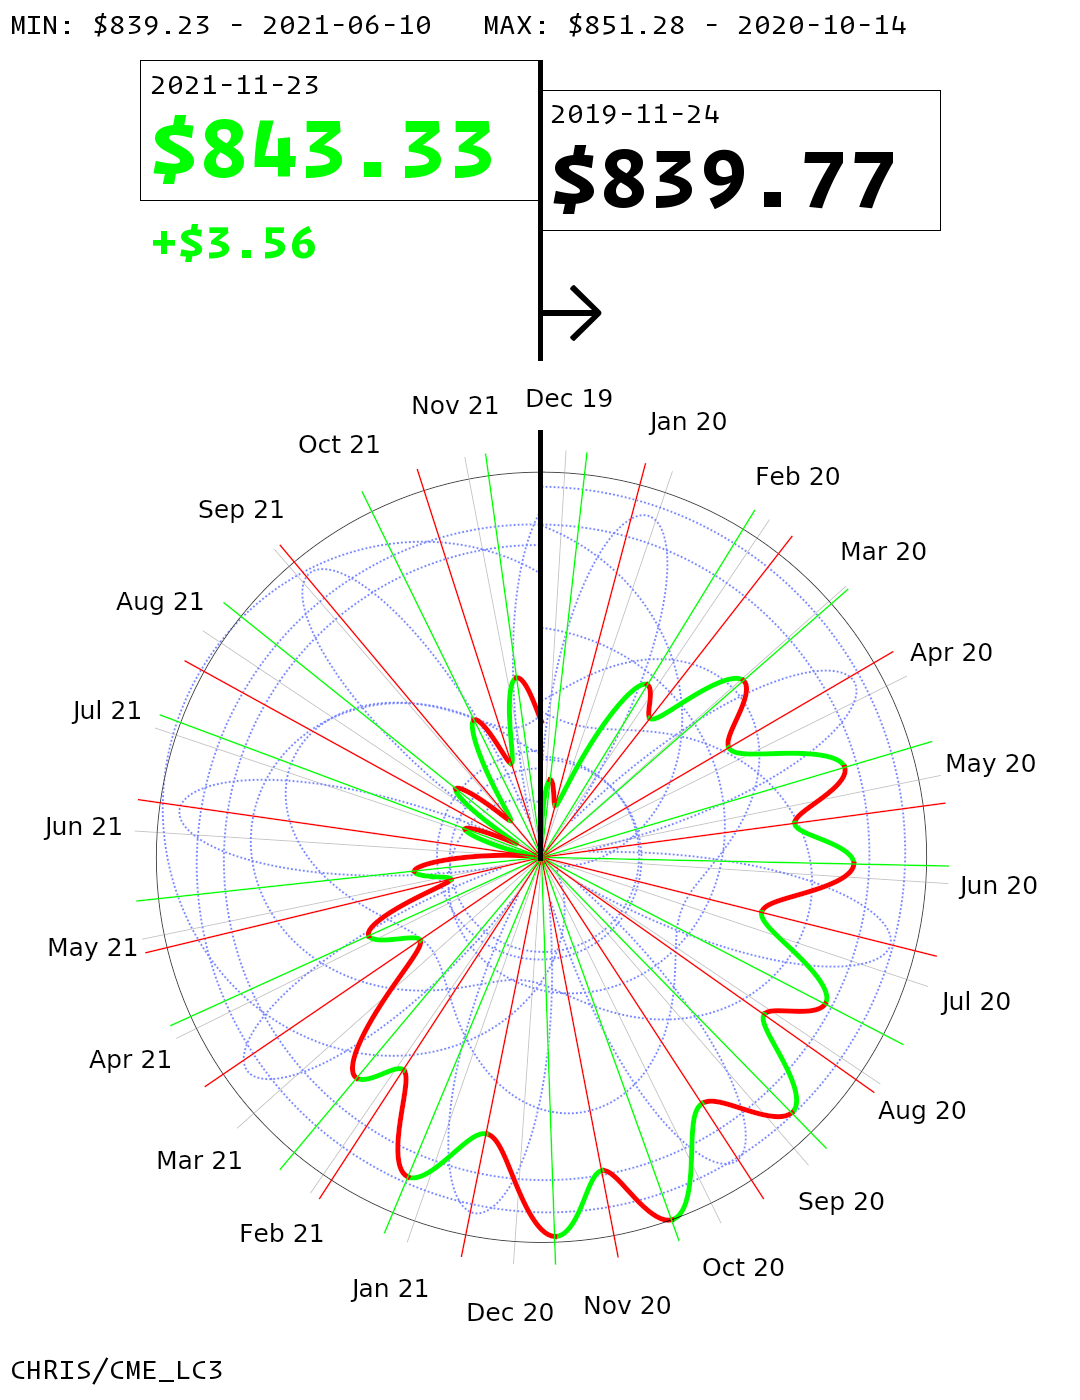

In [34]:
print(f"{query[0]} {query[1]} Chart")
print(f"{query[2]} Days, starting {chart_info[0]}")
print(f"Futures contract: {chart_info[4]}")
img

### Buying/Selling opportunities

In [35]:
# Buying Low
peaks_valleys.loc[peaks_valleys['direction'] == -1]

pred_price  direction                      date
1   840.708833       -1.0 2019-12-24 00:00:00+00:00
3   844.620229       -1.0 2020-02-09 00:00:00+00:00
5   845.922454       -1.0 2020-03-24 00:00:00+00:00
7   847.146554       -1.0 2020-05-09 00:00:00+00:00
9   846.235501       -1.0 2020-06-22 00:00:00+00:00
11  847.688958       -1.0 2020-08-04 00:00:00+00:00
13  848.372492       -1.0 2020-09-17 00:00:00+00:00
15  849.172357       -1.0 2020-11-01 00:00:00+00:00
17  847.990035       -1.0 2020-12-16 00:00:00+00:00
19  847.080302       -1.0 2021-01-29 00:00:00+00:00
21  843.683764       -1.0 2021-03-16 00:00:00+00:00
23  841.966451       -1.0 2021-04-27 00:00:00+00:00
25  839.226117       -1.0 2021-06-10 00:00:00+00:00
27  839.930071       -1.0 2021-07-22 00:00:00+00:00
29  840.535895       -1.0 2021-09-03 00:00:00+00:00
31  842.138410       -1.0 2021-10-18 00:00:00+00:00

In [36]:
# Selling High
peaks_valleys.loc[peaks_valleys['direction'] == 1]

pred_price  direction                      date
0   841.486027        1.0 2019-12-07 00:00:00+00:00
2   845.453643        1.0 2020-01-27 00:00:00+00:00
4   847.557736        1.0 2020-03-02 00:00:00+00:00
6   849.083526        1.0 2020-04-21 00:00:00+00:00
8   848.961004        1.0 2020-05-27 00:00:00+00:00
10  849.182710        1.0 2020-07-19 00:00:00+00:00
12  850.404279        1.0 2020-08-25 00:00:00+00:00
14  851.281445        1.0 2020-10-14 00:00:00+00:00
16  851.097627        1.0 2020-11-19 00:00:00+00:00
18  850.044612        1.0 2021-01-08 00:00:00+00:00
20  848.182510        1.0 2021-02-12 00:00:00+00:00
22  845.052088        1.0 2021-04-05 00:00:00+00:00
24  843.077891        1.0 2021-05-12 00:00:00+00:00
26  841.600419        1.0 2021-07-05 00:00:00+00:00
28  842.495473        1.0 2021-08-11 00:00:00+00:00
30  843.879361        1.0 2021-10-01 00:00:00+00:00
32  844.777843        1.0 2021-11-07 00:00:00+00:00